In [1]:
import datacleaner as dtclean
import dataexplore as dtexp
from view import data_visualization as dtview
import pandas as pd
import numpy as np
from fbprophet import Prophet
import forecast_metrics
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools
import matplotlib.pyplot as plt
# Offline mode
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import warnings

warnings.filterwarnings('ignore')
# "high resolution"
%config InlineBackend.figure_format = 'retina'
init_notebook_mode(connected=True)

# Visualizando o dataframe

In [2]:
df_274_time_sale = dtclean.get_Dataframes_time(274,'s')
df_274_time_sale.reset_index(inplace=True)
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

iplot(dtview.plot_dataframe_as_table(df_274_time_sale))

# Análise dos Dados

In [3]:
iplot(dtview.plot_scatter(df_274_time_sale,title='Vendas/hora (março-maio de 2020)'))

In [4]:
df_new = dtexp.date_features(df_274_time_sale)
iplot(dtview.plot_df_features_as_table(df_new))

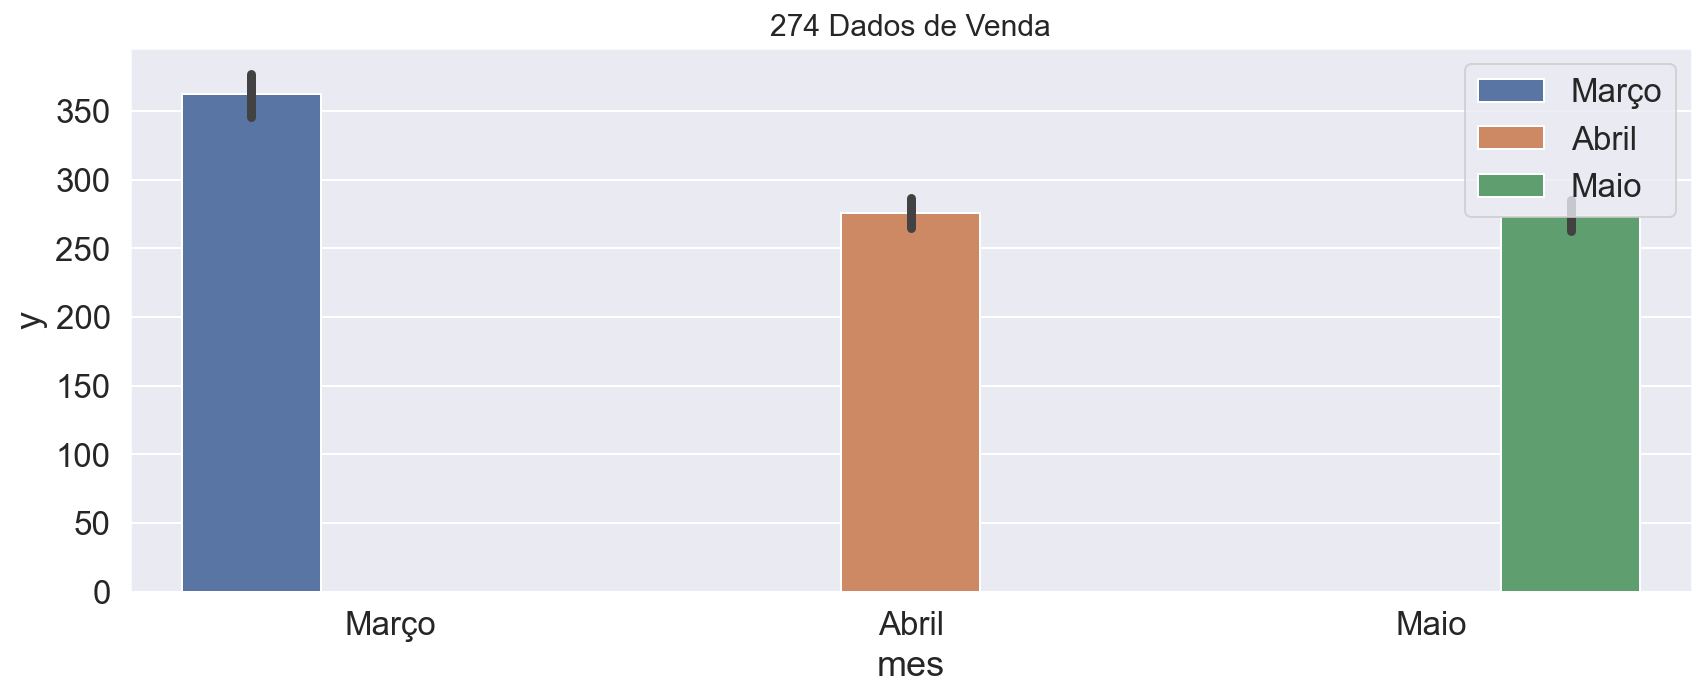

In [5]:
fig, ax = plt.subplots(figsize=(14,5))
dtview.plot_df_features(df_new,fig, ax).show()
#plt.show()

Text(0.5, 1.0, 'Total Vendas Por Dia da Semana')

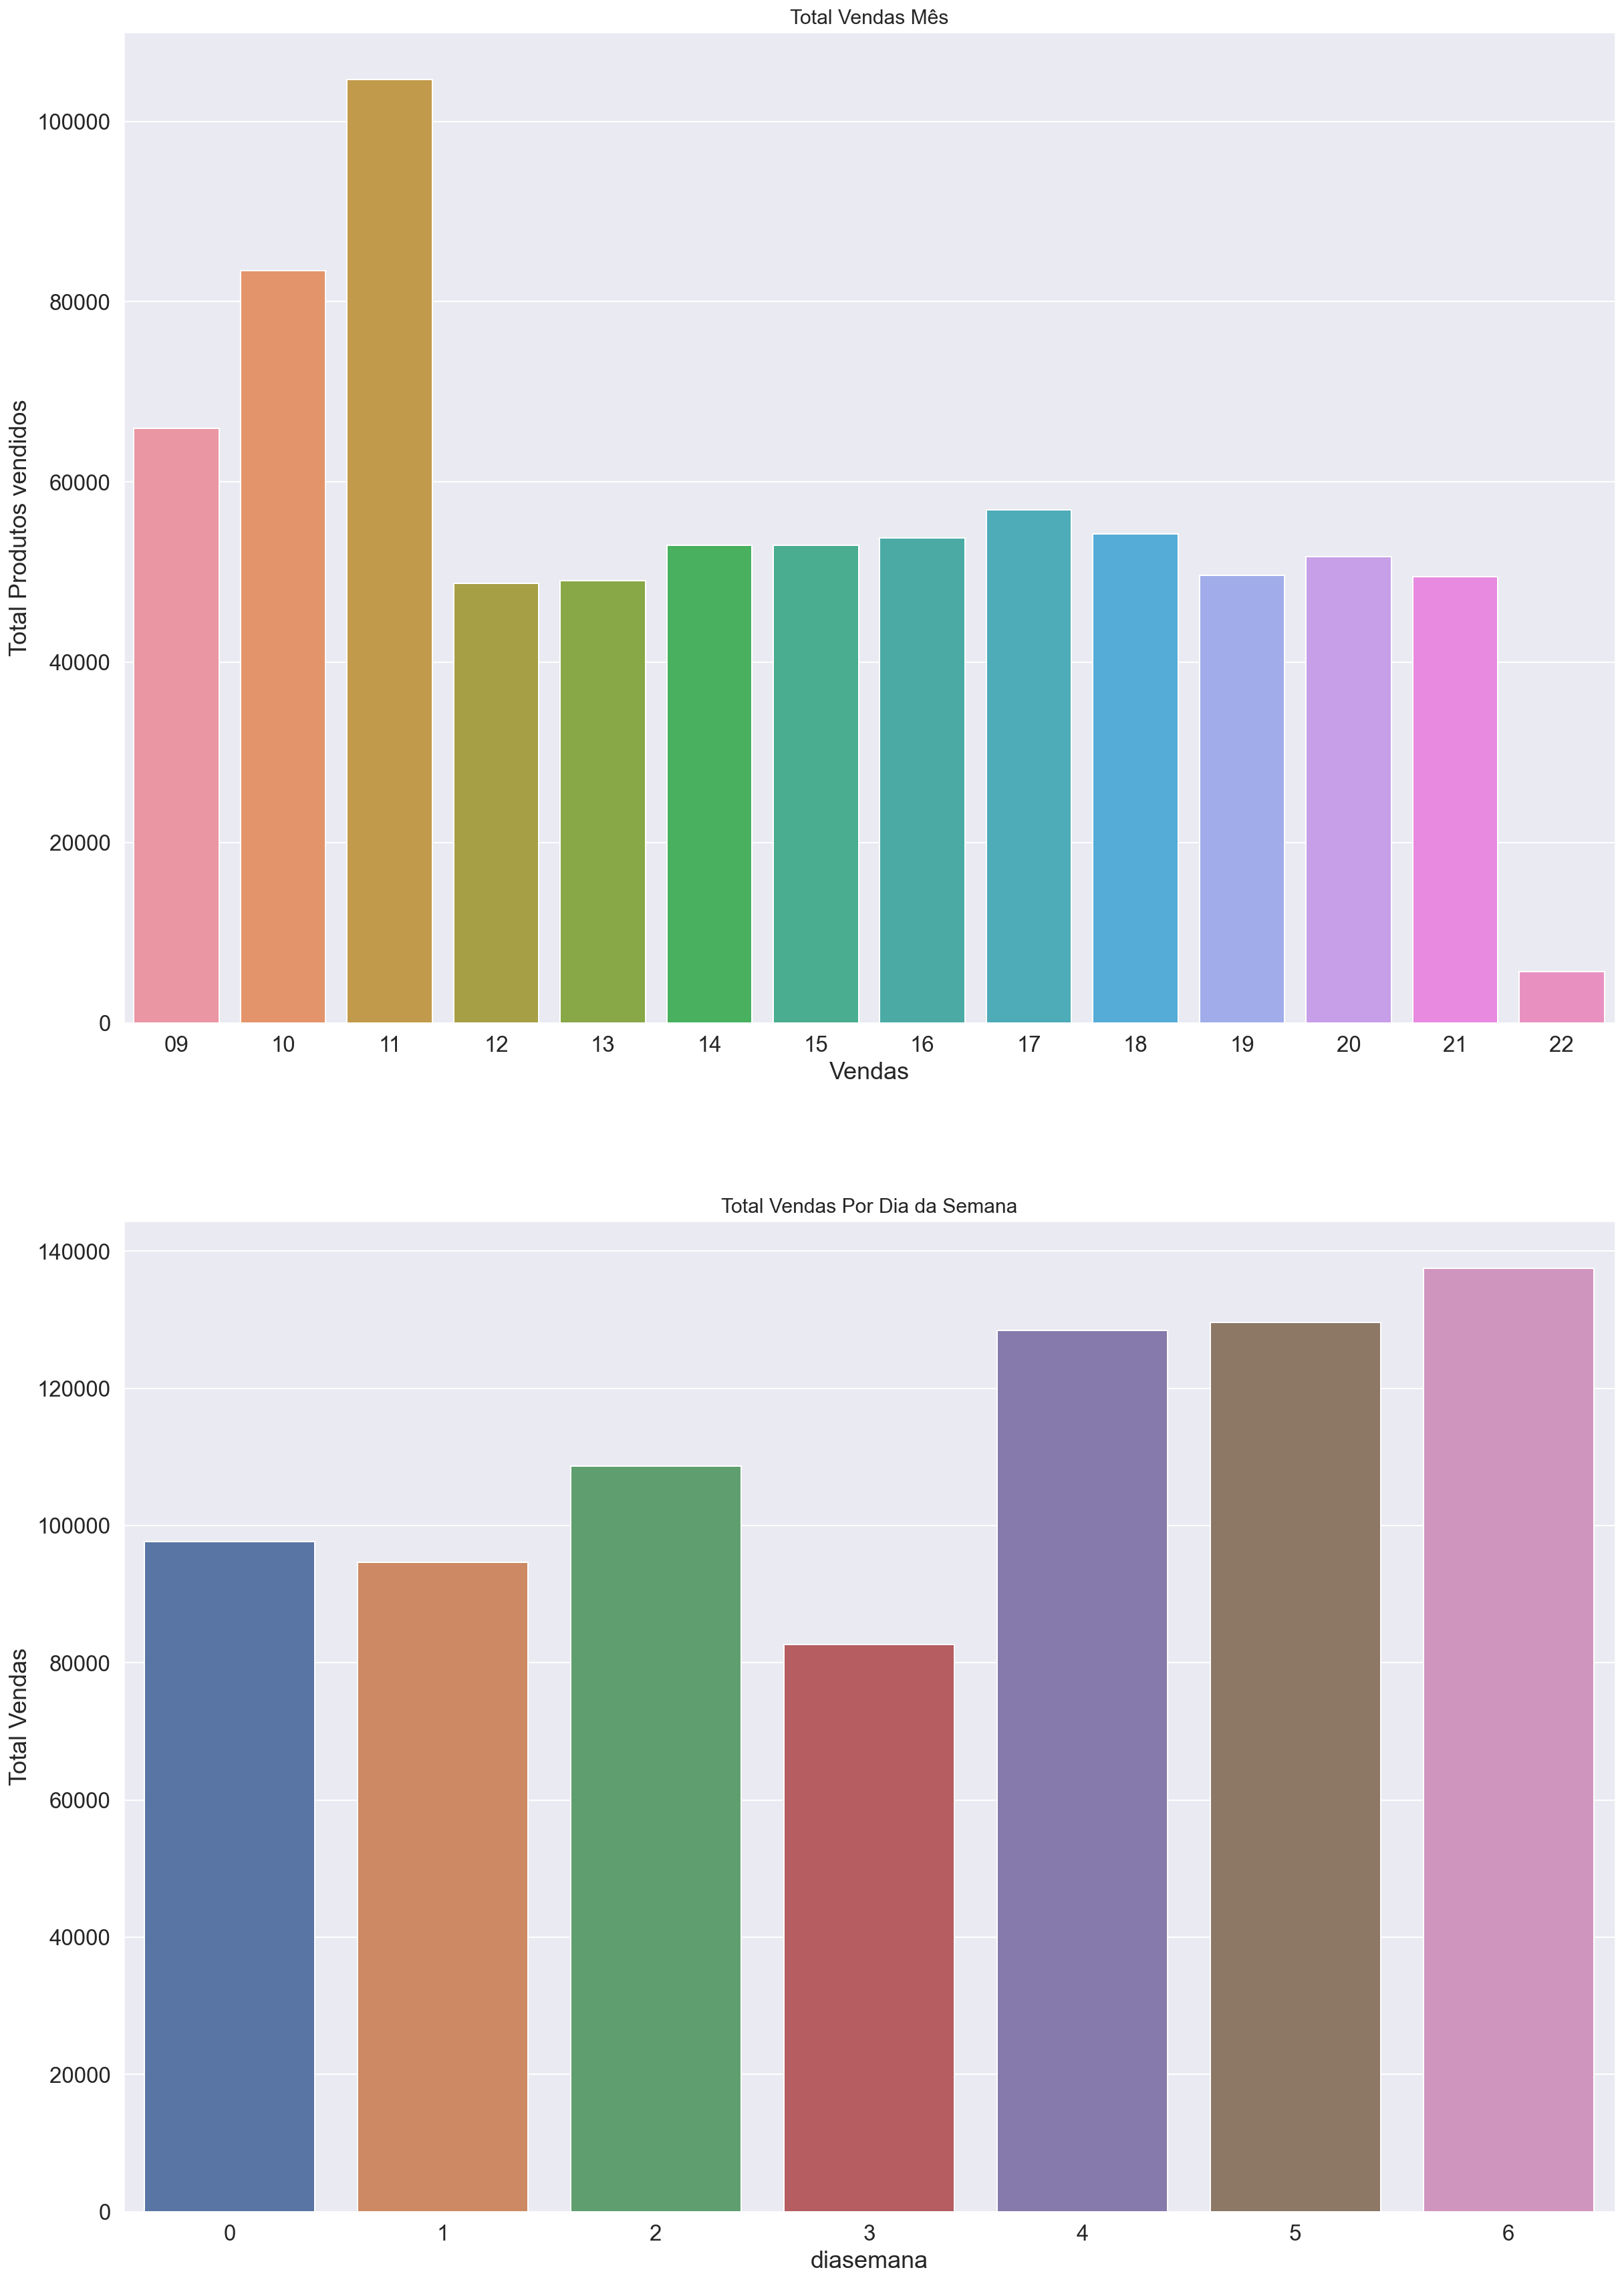

In [6]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,30)

mesAgregado = pd.DataFrame(df_new.groupby("semana")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=mesAgregado,x="semana",y="y",ax=ax1)
ax1.set(xlabel='Vendas', ylabel='Total Produtos vendidos')
ax1.set_title("Total Vendas Mês",fontsize=15)

semanaAgregada = pd.DataFrame(df_new.groupby("num")["y"].sum()).reset_index().sort_values('num')
sns.barplot(data=semanaAgregada,x="num",y="y",ax=ax2)
ax2.set(xlabel='diasemana', ylabel='Total Vendas')
ax2.set_title("Total Vendas Por Dia da Semana",fontsize=15)

In [7]:
df_274_sale_treino, df_274_sale_teste = dtexp.configura_dataframe_treino_teste(df_274_time_sale)
df_274_sale_treino['cap'] = 2724
df_274_sale_teste['cap'] = 2724
df_274_sale_treino['floor'] = 1.3
df_274_sale_teste['floor'] = 1.3
print('-'*60)
print('Shape dataframe de treino --> {}'.format(df_274_sale_treino.shape))
print('Shape dataframe de teste --> {}'.format(df_274_sale_teste.shape))
print('-'*60)

------------------------------------------------------------
Shape dataframe de treino --> (2344, 4)
Shape dataframe de teste --> (211, 4)
------------------------------------------------------------


# Visualizando o montante de dados para os datasets de treino e de teste

In [8]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_treino,
                                   df_274_sale_teste,
                                   title='Montante de dados de vendas de Treinamento e Teste',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [9]:
prophet = Prophet()
prophet.fit(df_274_sale_treino)
future_vendas = prophet.make_future_dataframe(periods=7, freq='D')
future_vendas['cap'] = 2724
future_vendas['floor'] = 1.3
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_vendas['ds'] = pd.to_datetime(future_vendas['ds'])
future_vendas = future_vendas.set_index(pd.DatetimeIndex(future_vendas['ds']))
future_vendas = future_vendas.between_time('08:00','21:00')

forecast_vendas = prophet.predict(future_vendas)

iplot(dtview.plot_forecast_as_table(forecast_vendas))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


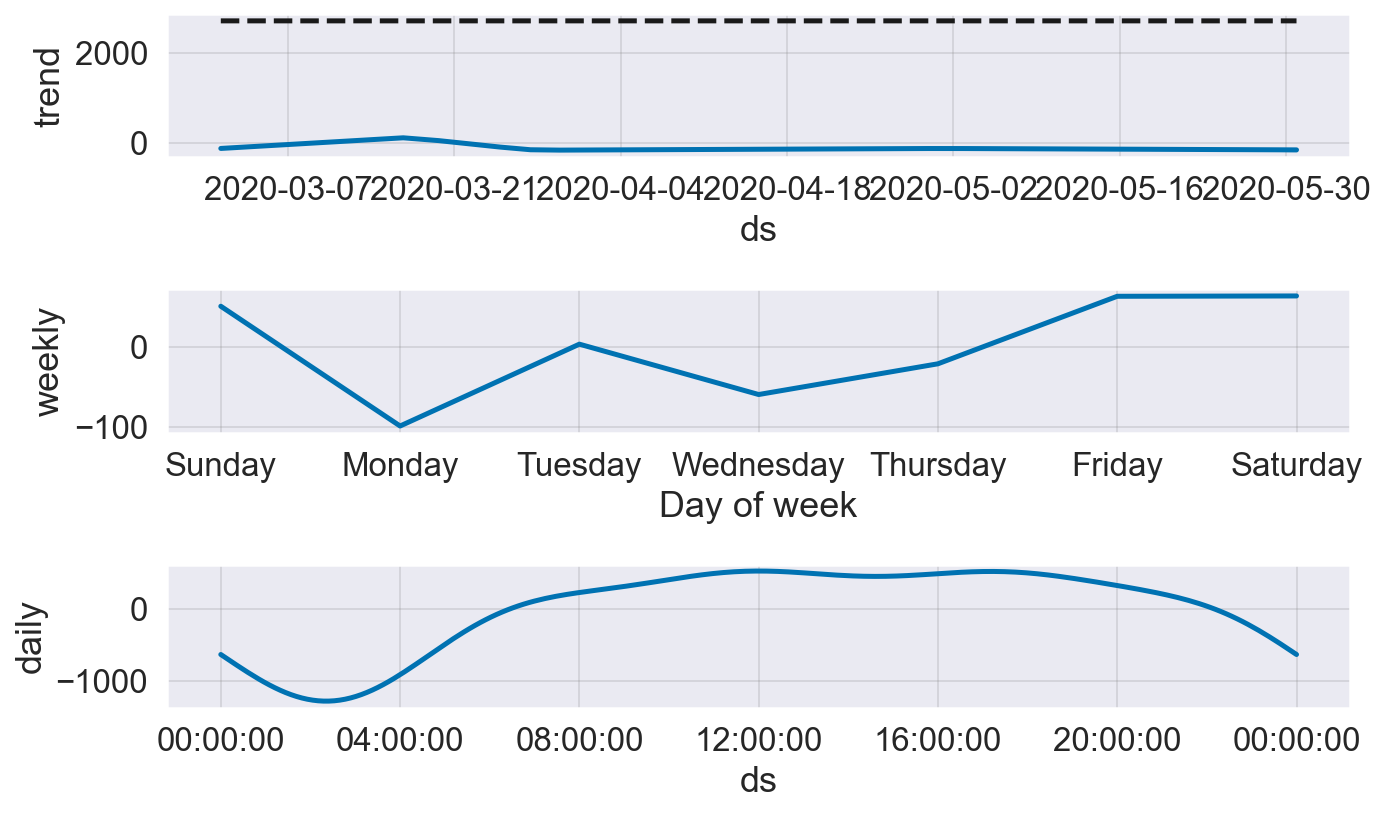

In [10]:
# componentes

fig = prophet.plot_components(forecast_vendas, figsize=(10,6))

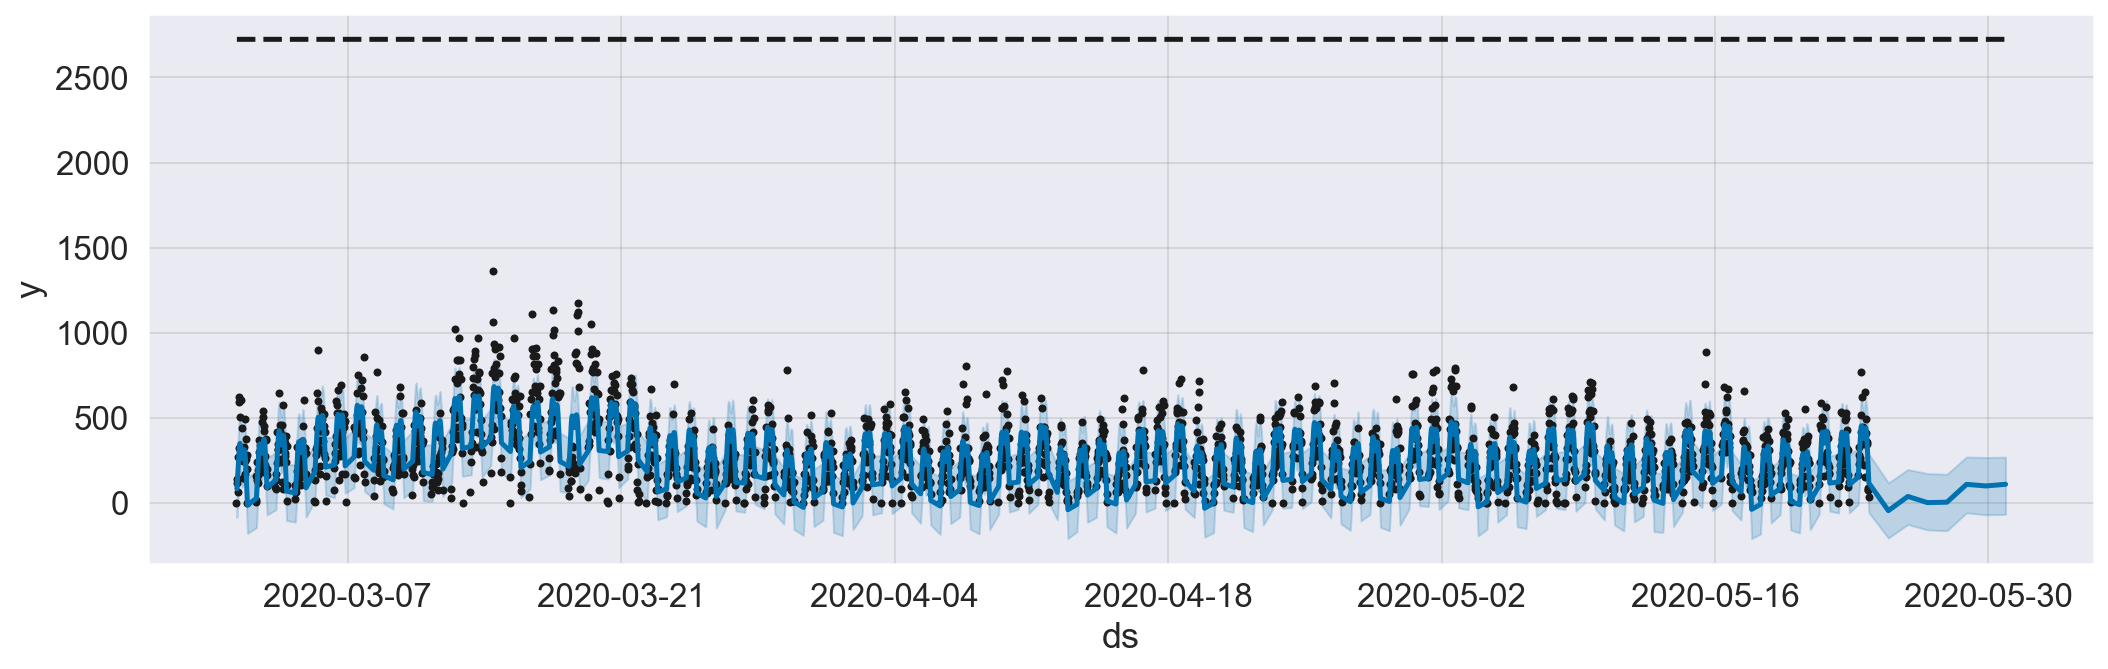

In [11]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet.plot(forecast_vendas,ax=ax)
plt.show()

In [12]:
df_274_sale_teste_forecast = prophet.predict(df_274_sale_teste)
iplot(dtview.plot_forecast_as_table(df_274_sale_teste_forecast))

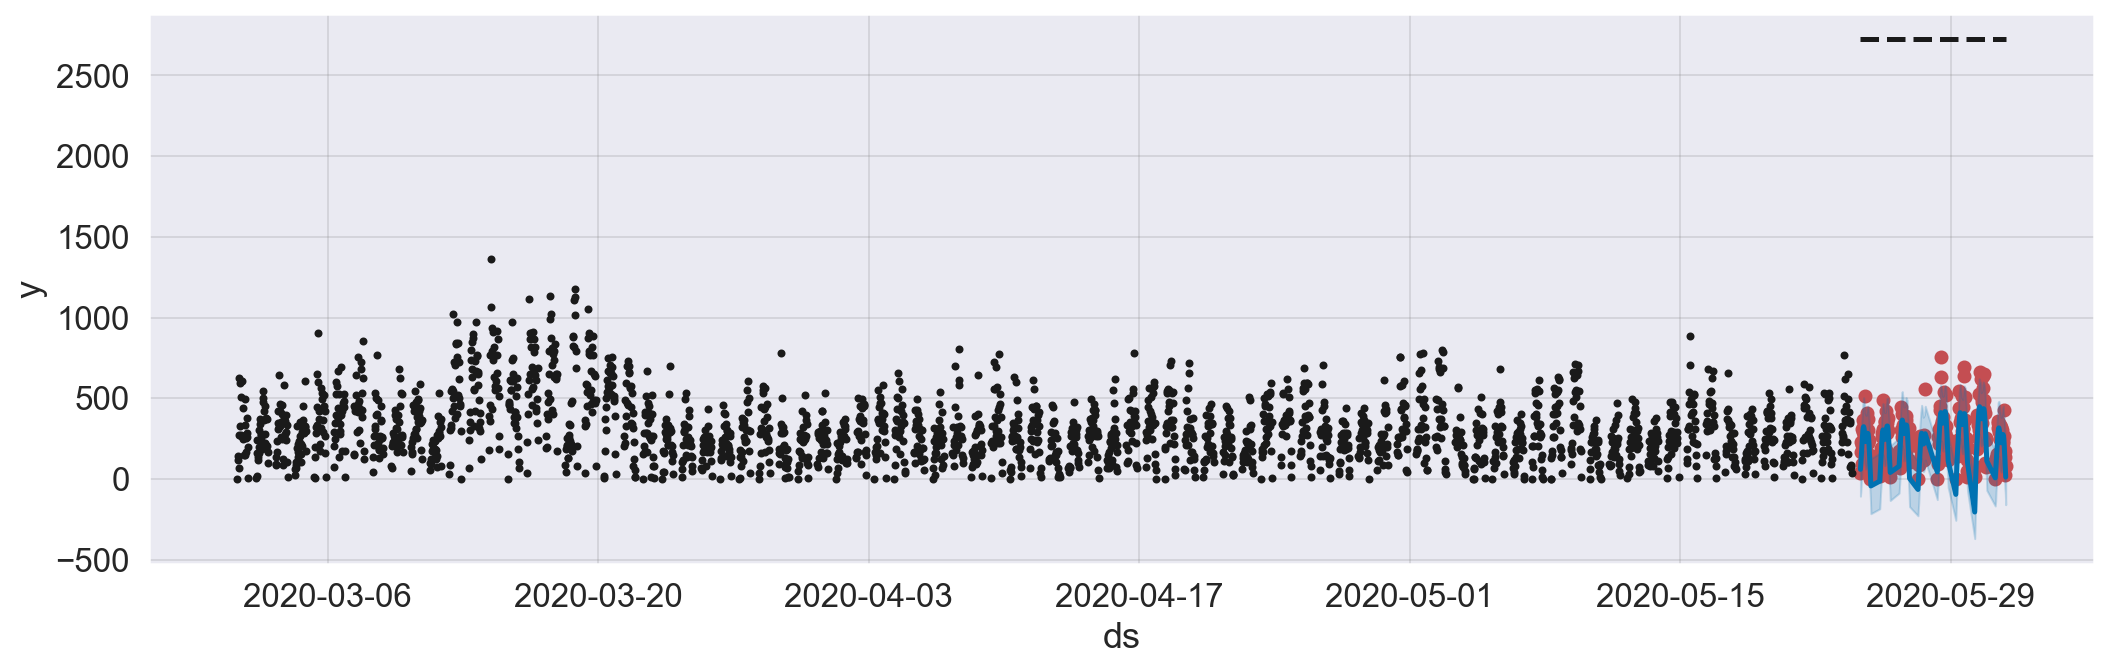

In [13]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sale_teste.ds,df_274_sale_teste['y'], color='r')
fig = prophet.plot(df_274_sale_teste_forecast,ax=ax)
plt.show()


# Comparação entre as vendas previstas e realizadas


In [14]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_teste,
                                   df_274_sale_teste_forecast,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

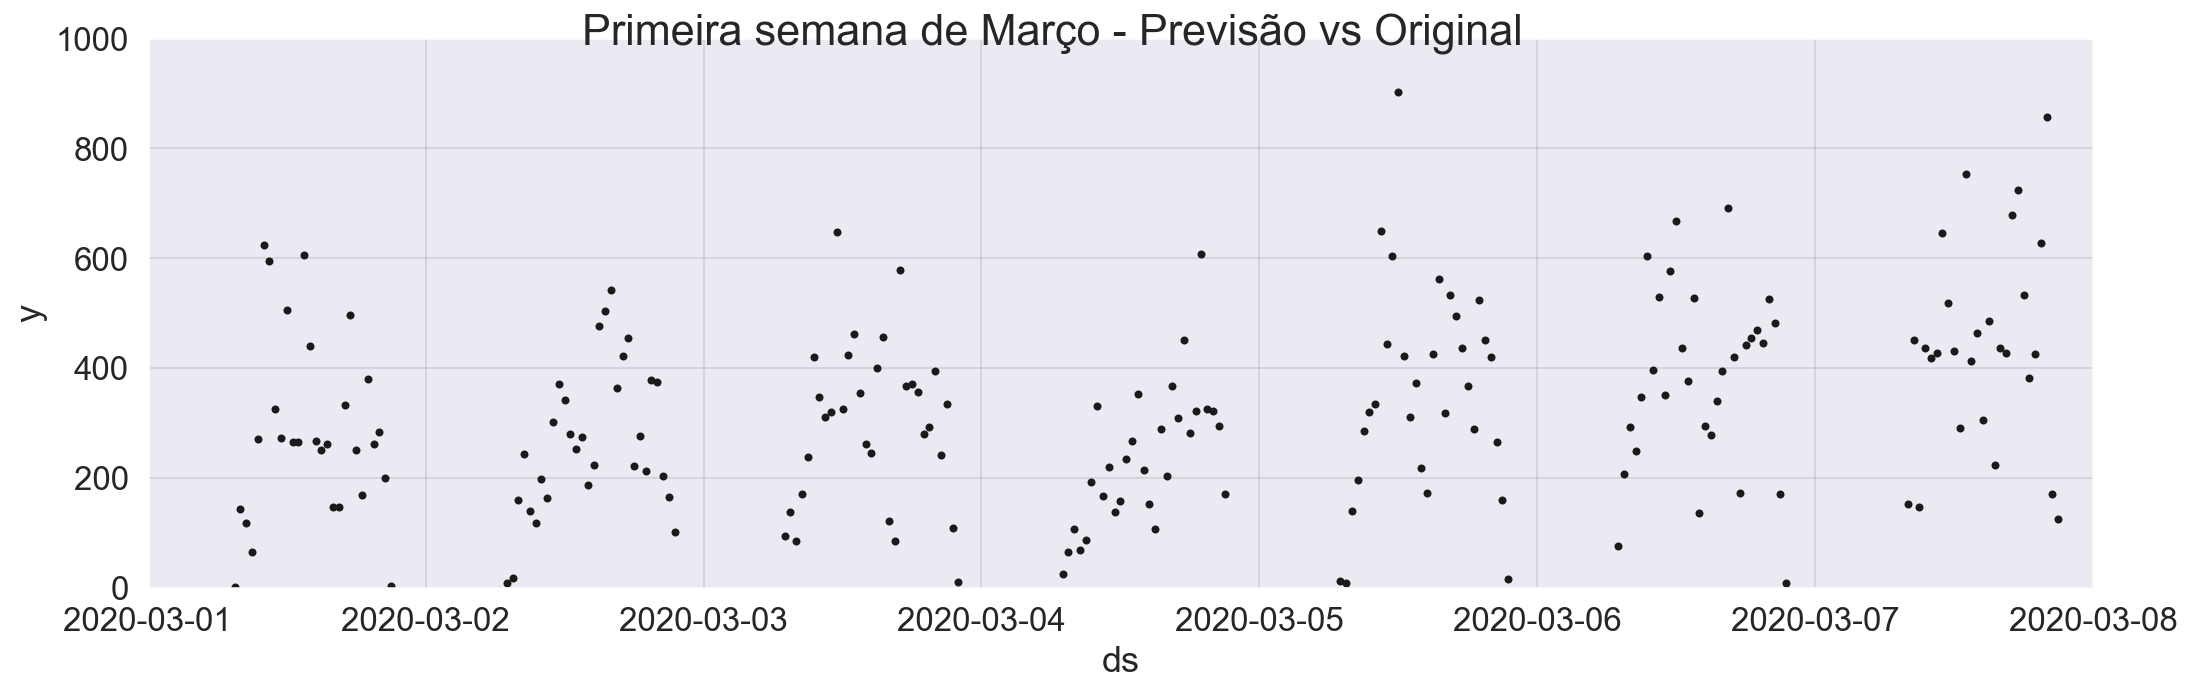

In [15]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sale_teste.ds, df_274_sale_teste['y'], color='r')
fig = prophet.plot(df_274_sale_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-03-01', upper='2020-03-08')
ax.set_ylim(0, 1000)
plot = plt.suptitle('Primeira semana de Março - Previsão vs Original')

In [16]:
mape_sem_feriados = dtexp.mean_absolute_percentage_error(df_274_sale_teste['y'],df_274_sale_teste_forecast['yhat'])
print("MAPE",round(mape_sem_feriados,4))

MAPE 160.4599


In [17]:
validando_mape = forecast_metrics.mape(df_274_sale_teste['y'],df_274_sale_teste_forecast['yhat'])
print("MAPE para validar",validando_mape)

MAPE para validar nan


In [18]:
y_true, y_pred = np.array(df_274_sale_teste['y']), np.array(df_274_sale_teste_forecast['yhat'])

iplot(dtview.compare_dataframes_with_bar(
    df_274_sale_teste,
    df_274_sale_teste_forecast,
    nametrace1='Valor Real',
    nametrace2='Valor Previsto',
    idx_end=28))


# Criando novo modelo com os feriados

In [19]:
# definindo o cap (carrying capacity)
#df_274_sale_treino['cap'] = 1362*2
#df_274_sale_treino['floor'] = 1
#df_274_sale_treino.reset_index(drop=True)
feriados = dtclean.get_Holiday()

In [20]:
prophet_feriados = Prophet(holidays=feriados)

prophet_feriados.add_country_holidays('BR')
prophet_feriados.fit(df_274_sale_treino)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em horas (os dados estão em horas)
future_feriados = prophet_feriados.make_future_dataframe(freq='D', periods=8)
# Prevendo os valores
forecast_feriados = prophet_feriados.predict(future_feriados)
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_feriados['ds'] = pd.to_datetime(future_feriados['ds'])
future_feriados = future_feriados.set_index(pd.DatetimeIndex(future_feriados['ds']))
future_feriados = future_feriados.between_time('08:00','21:00')
# Previsão optimizada dos valores
forecast_feriados = prophet_feriados.predict(future_feriados)
iplot(dtview.plot_forecast_as_table(forecast_feriados))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


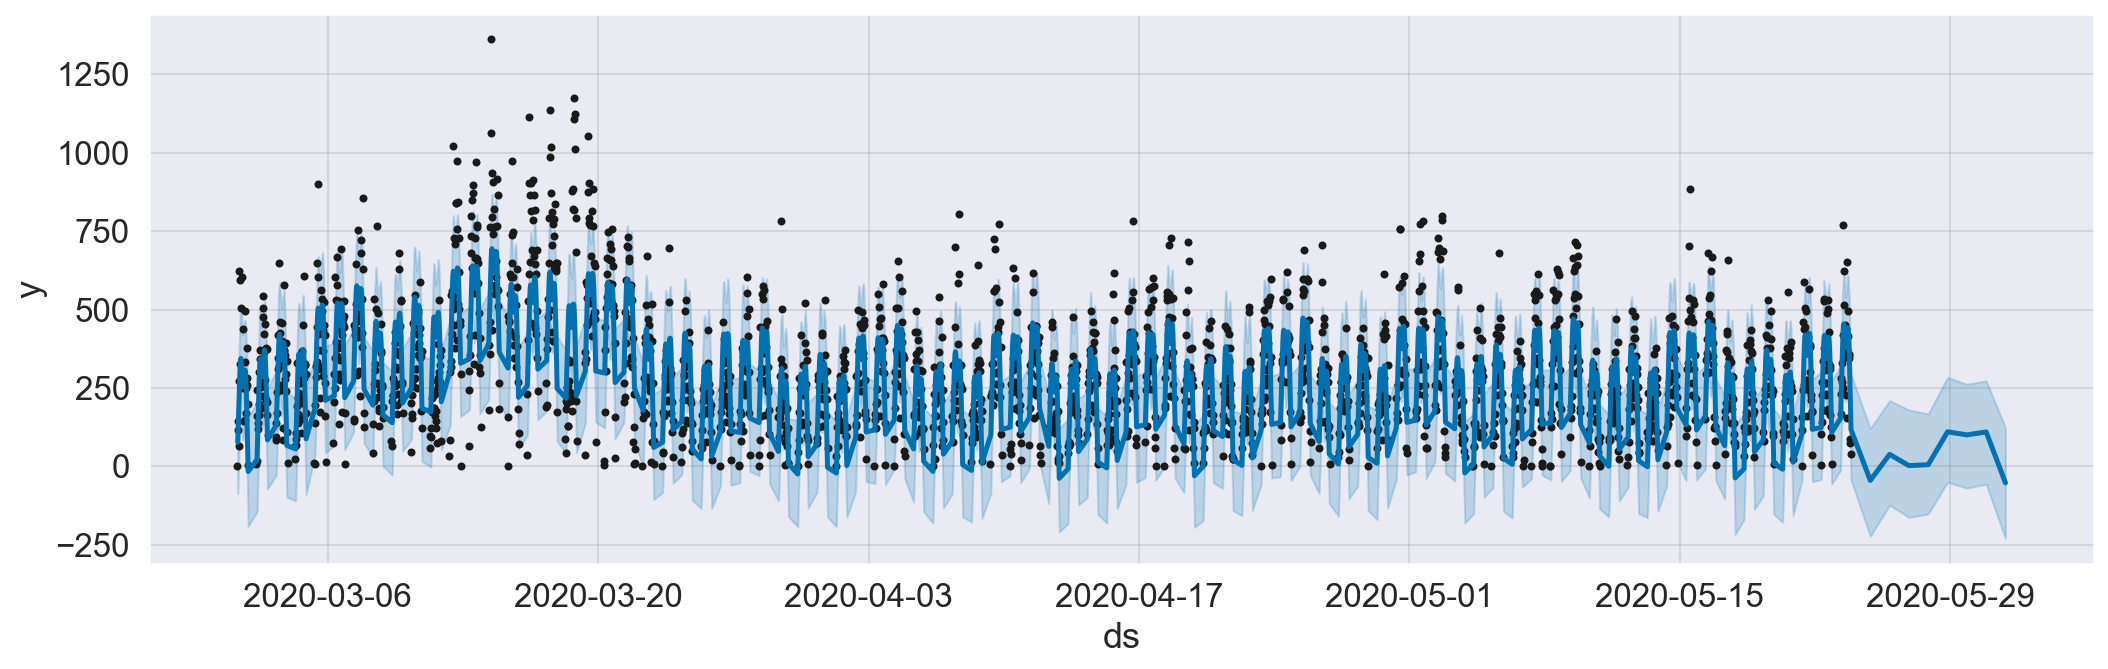

In [21]:
plt,fig_forecast_feriado = dtview.plot_forecast(forecast_feriados,prophet_feriados,f,ax)
plt.show()

# Visualizando os componentes do modelo

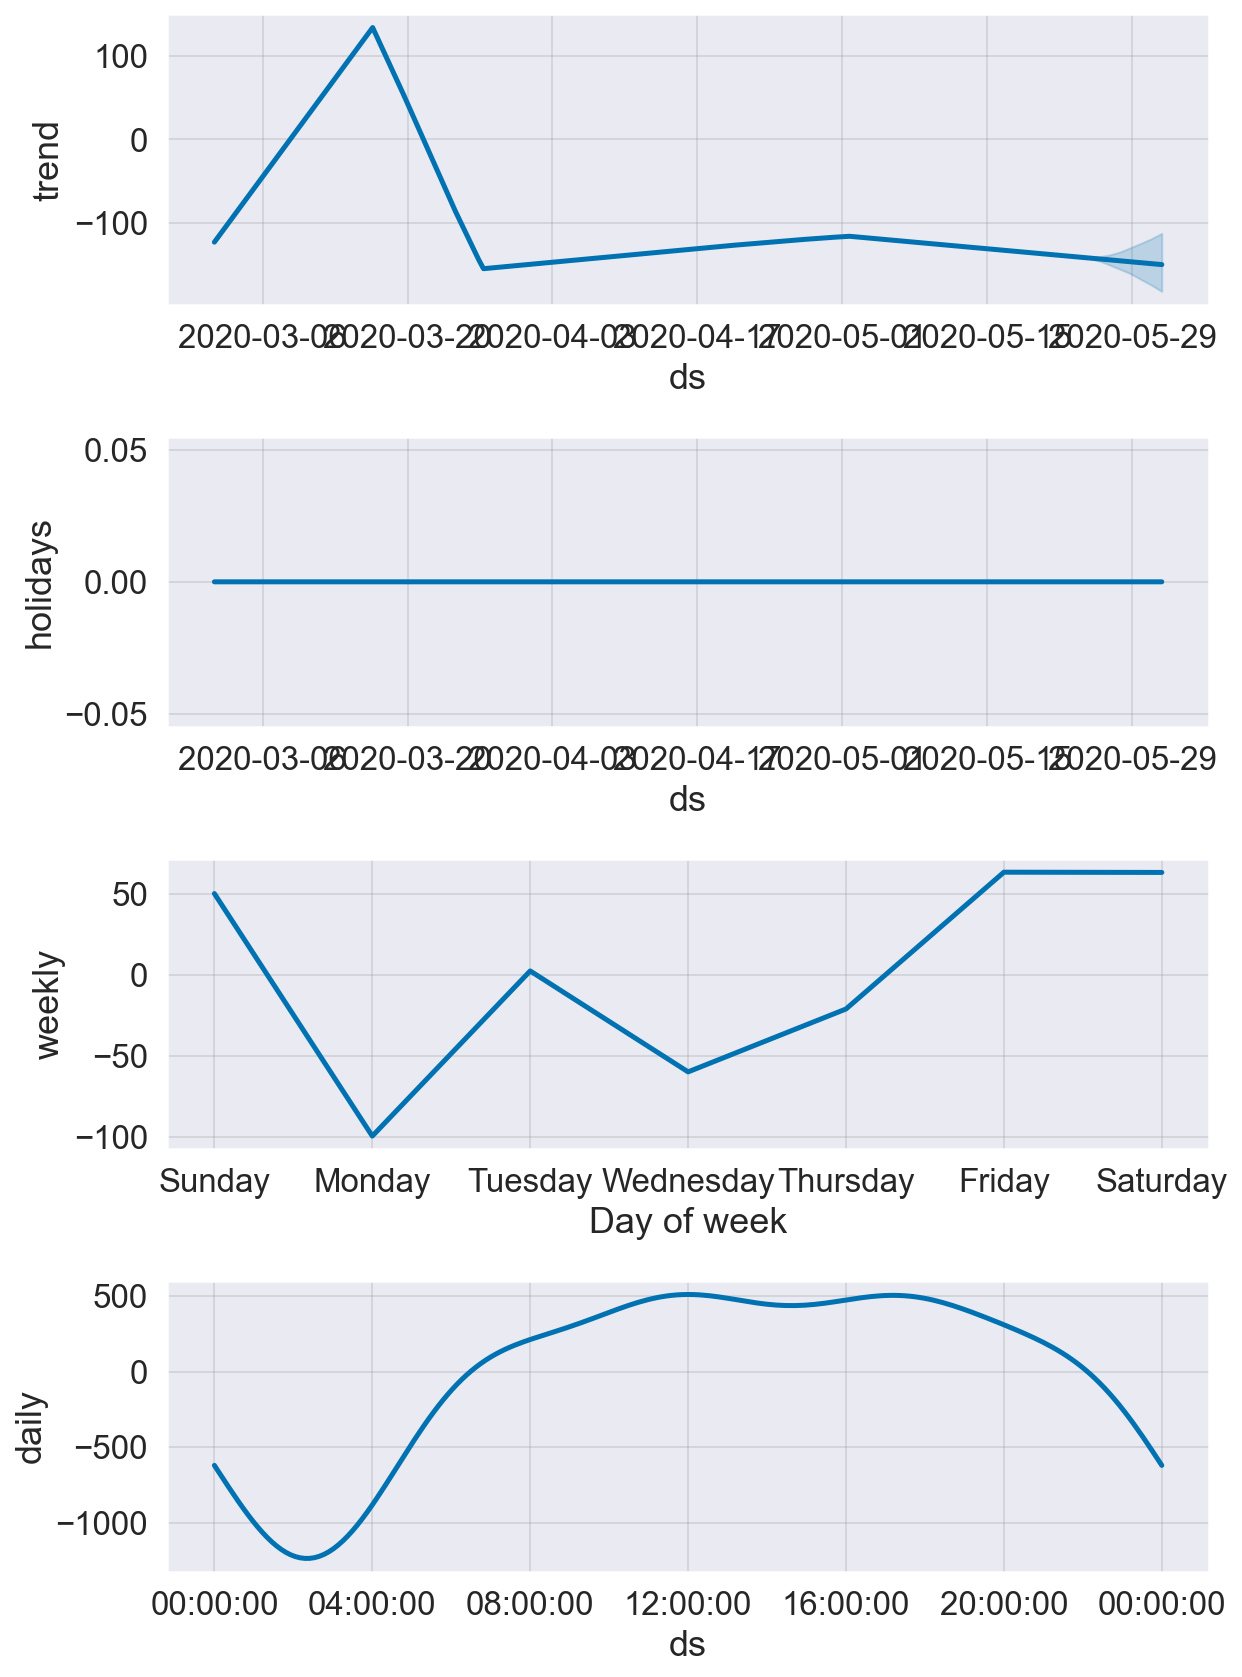

In [22]:
fig_forecast_feriado = prophet_feriados.plot_components(forecast_feriados)

## Visualizar tabela de previsão de teste

In [23]:
forecast_teste_feriados = prophet_feriados.predict(df_274_sale_teste)
iplot(dtview.plot_forecast_as_table(forecast_teste_feriados))

## Visualizar dataframe de teste previsto e original com feriados

In [24]:
iplot(dtview.compare_dataframes_with_scatter(
    df_274_sale_teste,
    forecast_teste_feriados,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [25]:
mape_com_feriados = dtexp.mean_absolute_percentage_error(df_274_sale_teste.y,forecast_teste_feriados.yhat)
print("MAPE",round(mape_com_feriados,4))

MAPE 156.9397


In [22]:
dtexp.tuning_model(df_274_sale_treino,df_274_time_sale,periodo=226,frequencia='D',loja='274',tipo='vendas')

In [26]:
parameters_df = pd.read_csv('model_parameters_274_vendas.csv',sep='\t')
parameters_df = parameters_df.sort_values(by=['MAPE'])
parameters_df = parameters_df.reset_index(drop=True)
parameters_df.drop(['Unnamed: 0'],axis=1,inplace=True)
trace_df_parameters=go.Table(header=dict(values=list(parameters_df[['MAPE','Parameters']])),
                            cells=dict(values=[parameters_df.MAPE,
                                               parameters_df.Parameters]))
data=[trace_df_parameters]
fig_df_parameters=go.Figure(data=data)
iplot(fig_df_parameters)


## Treinando o modelo com os melhores parâmetros identificados

+ changepoint_prior_scale= 15
+ holidays_prior_scale = 15
+ n_changepoints = 200
+ seasonality_mode = 'multiplicative'
+ seasonality_prior_scale = 15

In [27]:
# Configurando e treinando o modelo com feriados e parâmetros otimizados
final_prophet = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 15,
                      holidays_prior_scale = 15,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 25,
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_prophet.add_country_holidays(country_name='BR')
final_prophet.fit(df_274_sale_treino)

In [28]:
future_final = final_prophet.make_future_dataframe(periods=122, freq='D')
forecast_final = final_prophet.predict(future_final)
iplot(dtview.plot_forecast_as_table(forecast_final))

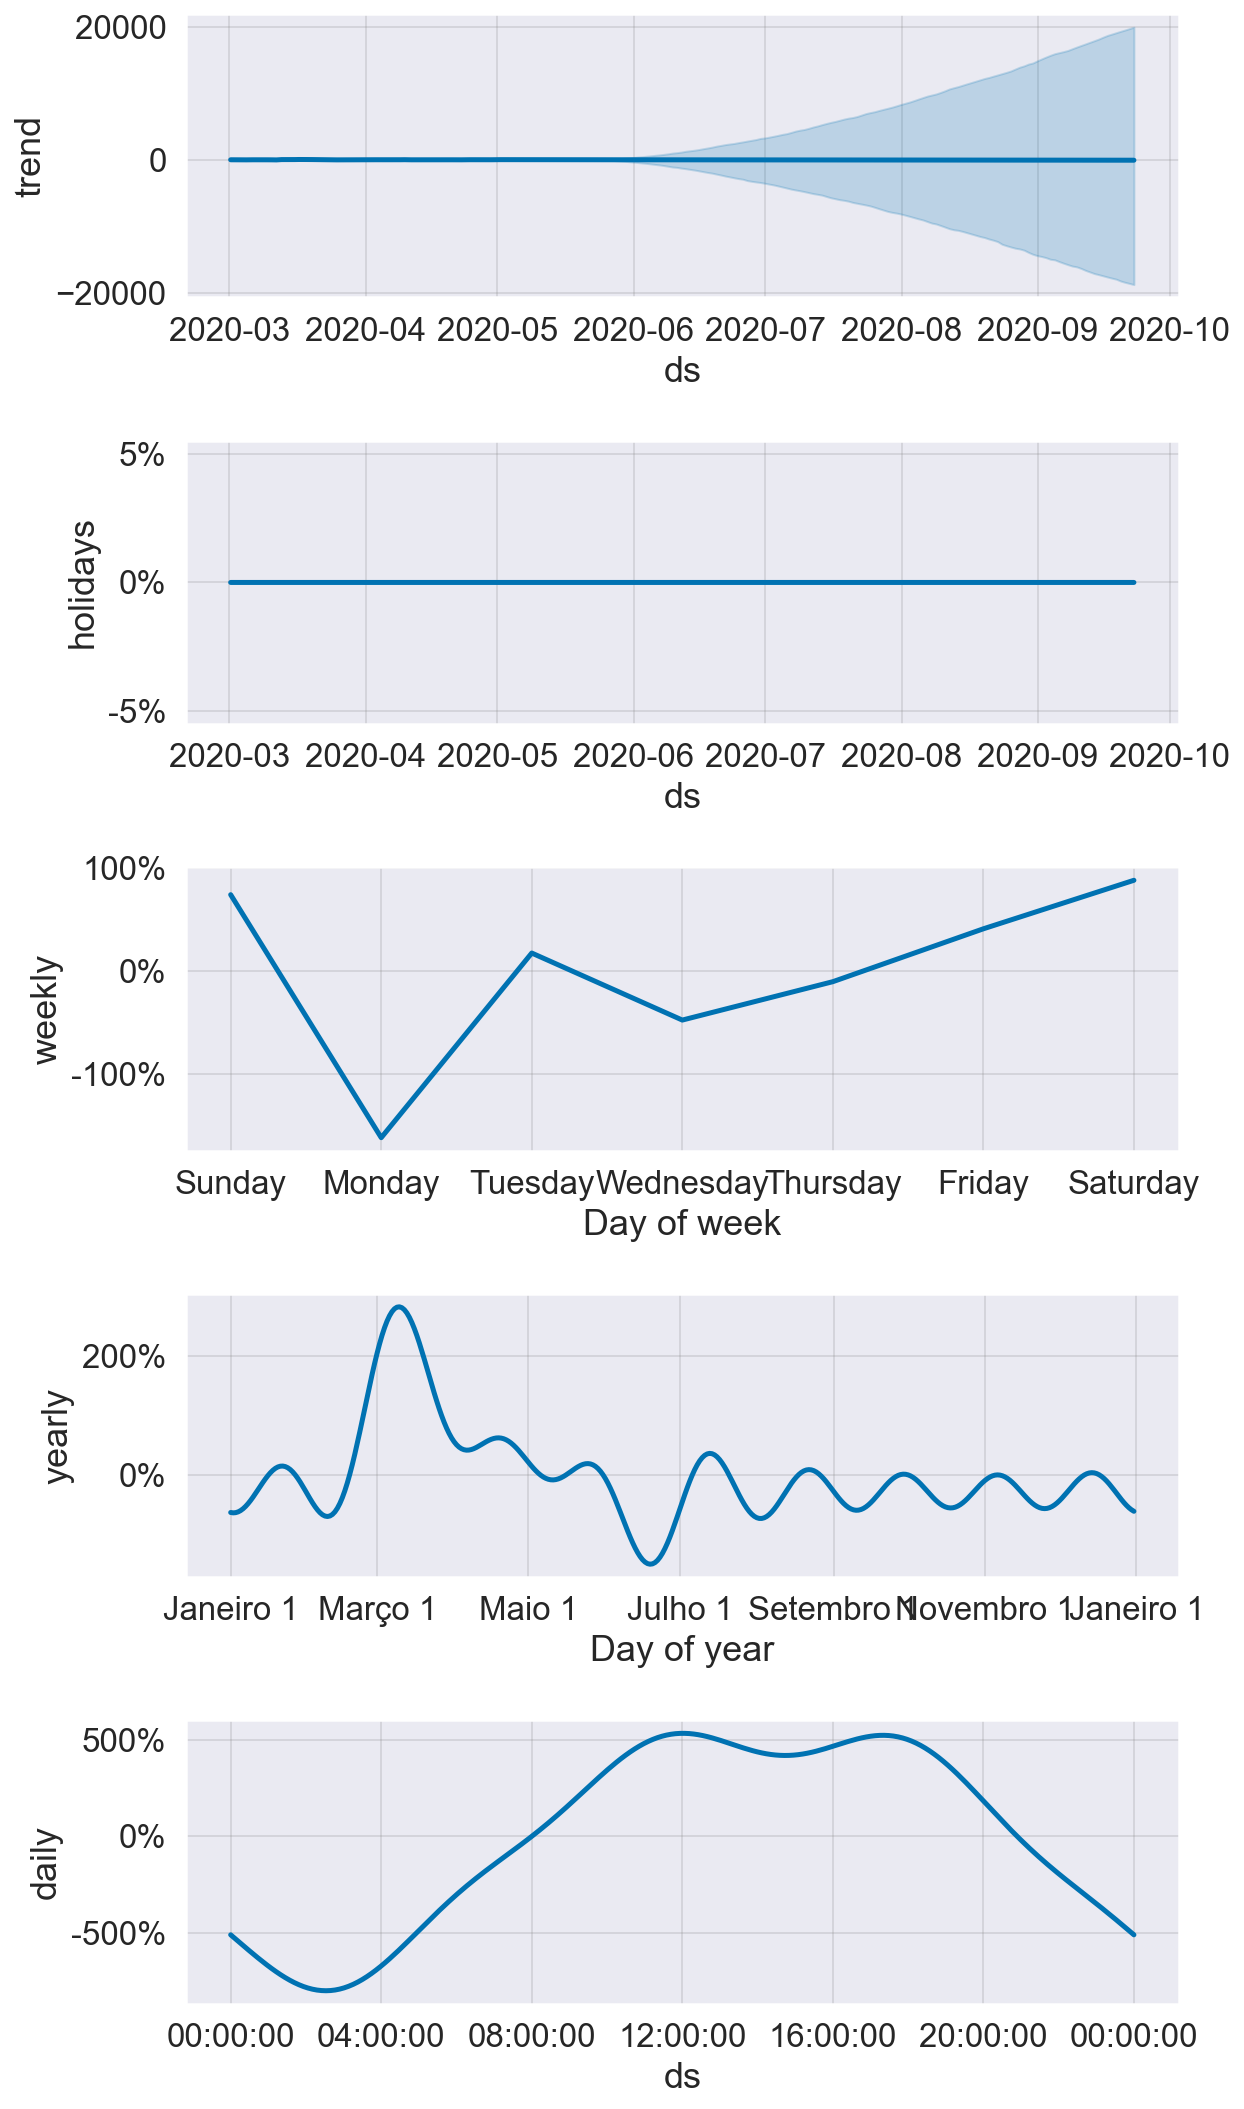

In [29]:
# Plot the components of the model
fig = final_prophet.plot_components(forecast_final)

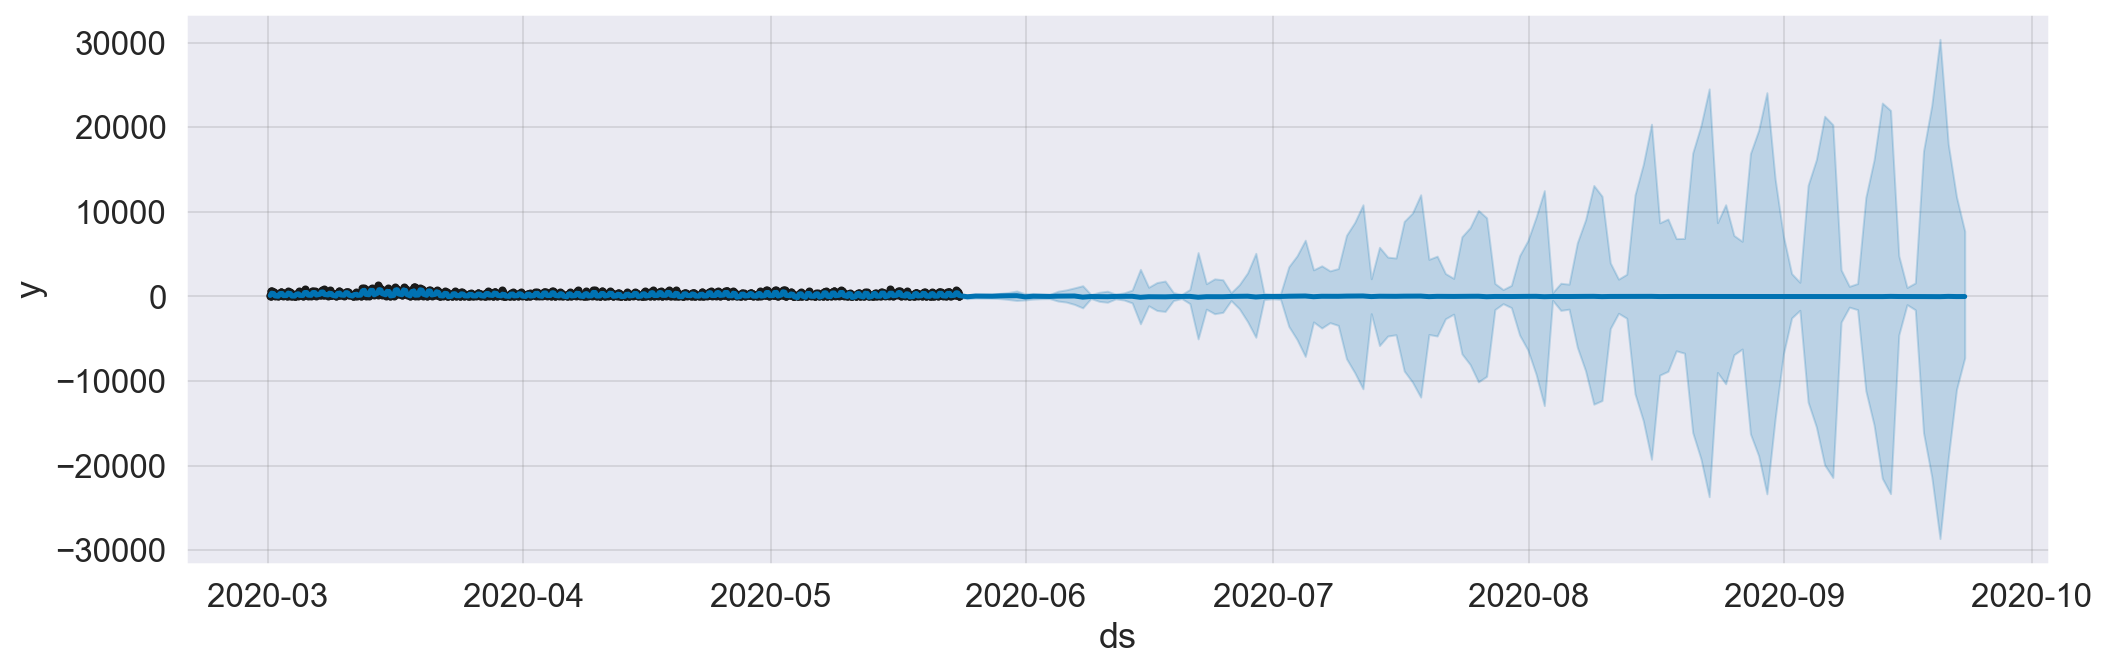

In [30]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_prophet.plot(forecast_final,ax=ax)
plt.show()

In [31]:
df_teste_final= final_prophet.predict(df_274_sale_teste)
iplot(dtview.plot_forecast_as_table(df_teste_final))

In [32]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_teste,
                                   df_teste_final,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

# Comparando os dataframes de teste e previsto em escala diária

In [33]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_sale_teste,
    df_teste_final,
    nametrace1='Teste',
    nametrace2='Previsto'))

In [34]:
mape_final = dtexp.mean_absolute_percentage_error(df_274_sale_teste['y'],df_teste_final['yhat'])
print("MAPE",round(mape_final,4))


MAPE 98.9409


In [35]:
y_true, y_pred = np.array(df_274_sale_teste['y']), np.array(df_teste_final['yhat'])
np.mean(np.abs((y_true - y_pred)))

80.62795917123967

In [36]:
outliers = dtexp.detect_outlier(df_274_time_sale['y'])
sorted(outliers)
lim_inf, lim_sup = dtexp.calculate_iqr_score(outliers)
print('Outlier inferior {}, outlier superior {}'.format(lim_inf,lim_sup))
k=670
result_vetor = [670]
print(type(result_vetor))
result_vetor = result_vetor.insert(1,k+1)
print(result_vetor)

Outlier inferior 670.75, outlier superior 1292.75
<class 'list'>
None


In [37]:
df = df_274_time_sale.loc[df_274_time_sale['y'].isin(outliers)]
df

ds     y
128  2020-03-05 12:00:00   902
328  2020-03-12 12:00:00  1022
338  2020-03-12 17:00:00   973
358  2020-03-13 12:00:00   896
366  2020-03-13 16:00:00   971
384  2020-03-14 10:30:00  1362
385  2020-03-14 11:00:00  1064
387  2020-03-14 12:00:00   937
390  2020-03-14 13:30:00   908
399  2020-03-14 18:00:00   915
417  2020-03-15 13:00:00   973
440  2020-03-16 10:00:00  1113
441  2020-03-16 10:30:00   904
444  2020-03-16 12:00:00   904
450  2020-03-16 15:00:00   912
473  2020-03-17 12:00:00   988
474  2020-03-17 12:30:00  1135
476  2020-03-17 13:30:00  1019
511  2020-03-18 16:30:00   886
513  2020-03-18 17:30:00  1108
515  2020-03-18 18:30:00  1176
516  2020-03-18 19:00:00  1013
517  2020-03-18 19:30:00  1125
531  2020-03-19 11:30:00  1055
533  2020-03-19 12:30:00   904
543  2020-03-19 17:30:00   885
2108 2020-05-15 12:30:00   886

In [38]:
df_sem_outliers = df_274_time_sale[df_274_time_sale['y'] < 670]
df_sem_outliers.info

<bound method DataFrame.info of                       ds    y
0    2020-03-01 07:30:00    2
1    2020-03-01 08:00:00  144
2    2020-03-01 08:30:00  117
3    2020-03-01 09:00:00   65
4    2020-03-01 09:30:00  271
...                  ...  ...
2550 2020-05-31 18:30:00  268
2551 2020-05-31 19:00:00  173
2552 2020-05-31 19:30:00  136
2553 2020-05-31 20:00:00   23
2554 2020-05-31 20:30:00   80

[2428 rows x 2 columns]>

In [39]:
dtview.plot_dataframe_as_table(df_sem_outliers)

# Visualizando os valores outliers

###### Outlier são pontos de dados se desviam de forma acentuada dos outros pontos de dados em uma mesma amostra, é chamado de outlier. Qualquer outra observação esperada é rotulada como um inlier"Outliers são os valores em uma série, que se afastam de forma imprevista, dos valores esperados. Isso pode ocorrer em função de características particulares que afetam a variável analisada, erro na transcrição/registo dos valores da variável, etc. A visualização gráfica desses valores em boxplot auxilia a compreender o quanto eles estão distante do valor esperado. A caixa de cor sólida, representa os valores esperados, isto é, o maior conjunto de valores que se repete na série, enquanto os pontos fora da caixa representam os outliers.
`Conforme esclarece Montgomery, os outliers são pontos de dados incomuns que devem ser devidamente identificados para análise futura`

In [40]:
dtview.check_outliers_univariate(df_274_time_sale)

In [42]:
# Configurando e treinando o modelo com feriados e parâmetros otimizados
prophet_sem_outliers = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 15,
                      holidays_prior_scale = 15,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 25,
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
prophet_sem_outliers.add_country_holidays(country_name='BR')
prophet_sem_outliers.fit(df_sem_outliers)

In [41]:

df_274_sem_outliers_treino, df_274_sem_outliers_teste = dtexp.configura_dataframe_treino_teste(df_sem_outliers)
print('-'*60)
print('Shape dataframe de treino --> {}'.format(df_274_sem_outliers_treino.shape))
print('Shape dataframe de teste --> {}'.format(df_274_sem_outliers_teste.shape))
print('-'*60)

------------------------------------------------------------
Shape dataframe de treino --> (2219, 2)
Shape dataframe de teste --> (209, 2)
------------------------------------------------------------


In [42]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_treino,
                                   df_274_sem_outliers_teste,
                                   title='Montante de dados de vendas de Treinamento e Teste (sem outliers)',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [43]:
prophet_no_outliers = Prophet()
prophet_no_outliers.fit(df_274_sem_outliers_treino)
future_no_outliers = prophet_no_outliers.make_future_dataframe(periods=7, freq='D')
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_no_outliers['ds'] = pd.to_datetime(future_no_outliers['ds'])
future_no_outliers = future_no_outliers.set_index(pd.DatetimeIndex(future_no_outliers['ds']))
future_no_outliers = future_no_outliers.between_time('08:00','21:00')

forecast_no_outliers = prophet_no_outliers.predict(future_no_outliers)

iplot(dtview.plot_forecast_as_table(forecast_no_outliers))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


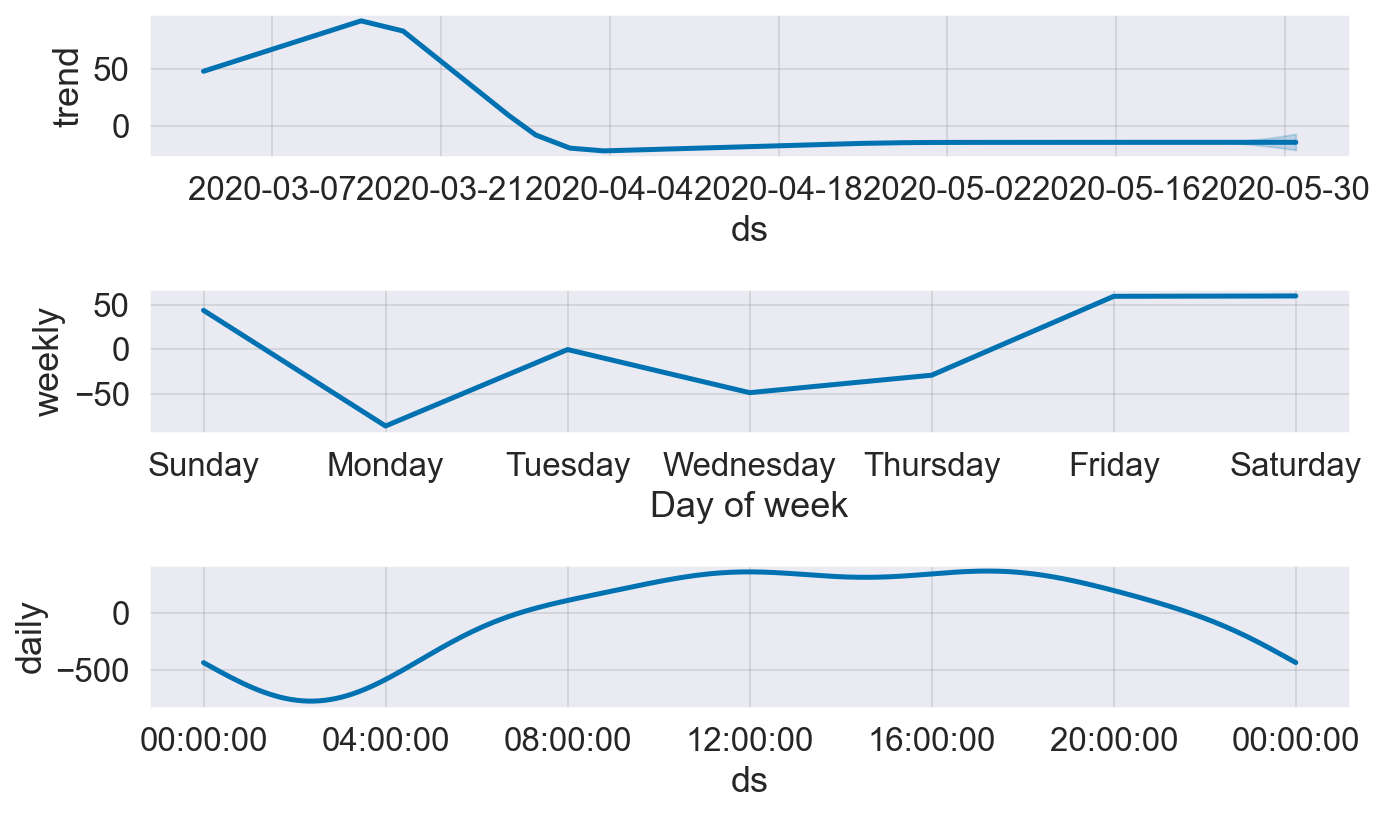

In [44]:
# componentes

fig = prophet_no_outliers.plot_components(forecast_no_outliers, figsize=(10,6))


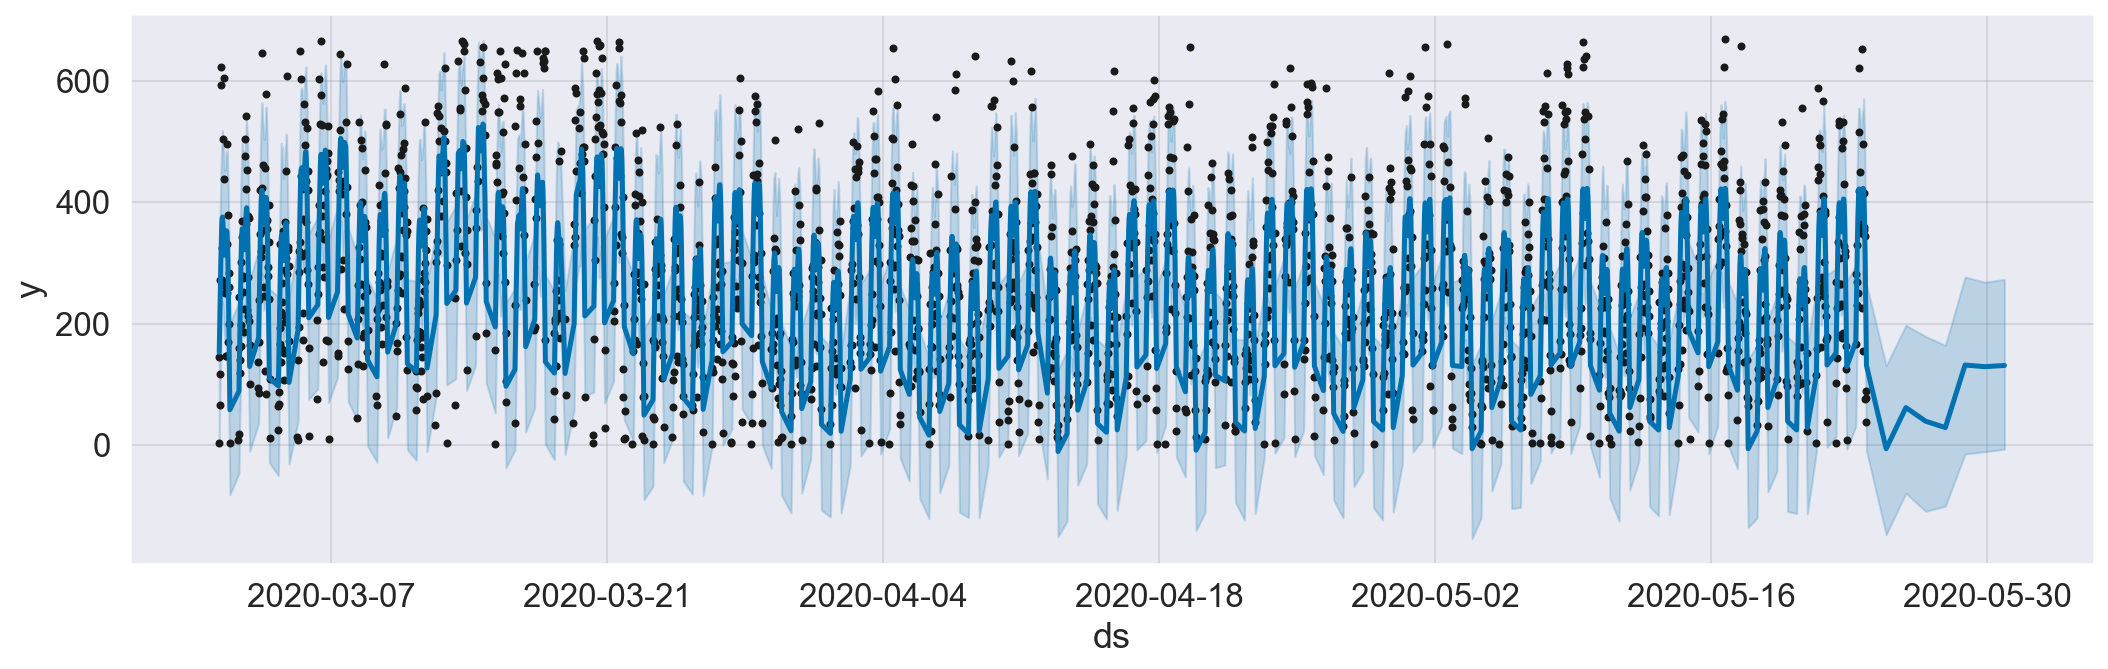

In [45]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet_no_outliers.plot(forecast_no_outliers,ax=ax)
plt.show()

In [46]:
df_274_no_outliers_teste_forecast = prophet_no_outliers.predict(df_274_sem_outliers_teste)
iplot(dtview.plot_forecast_as_table(df_274_no_outliers_teste_forecast))

In [47]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_teste,
                                   df_274_no_outliers_teste_forecast,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

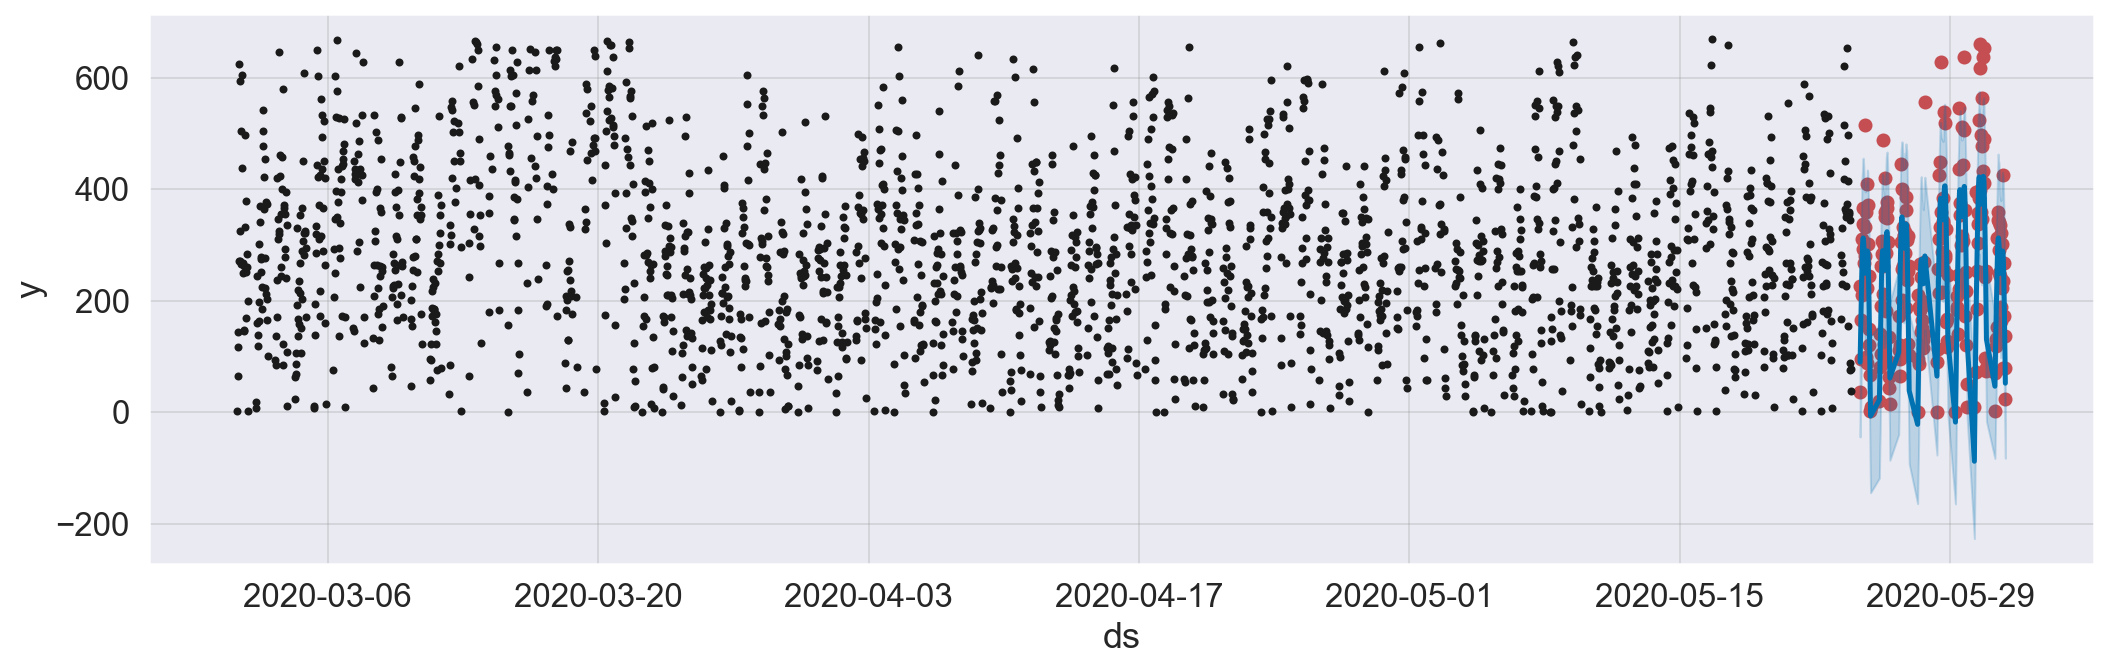

In [48]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sem_outliers_teste.ds,df_274_sem_outliers_teste['y'], color='r')
fig = prophet_no_outliers.plot(df_274_no_outliers_teste_forecast,ax=ax)
plt.show()

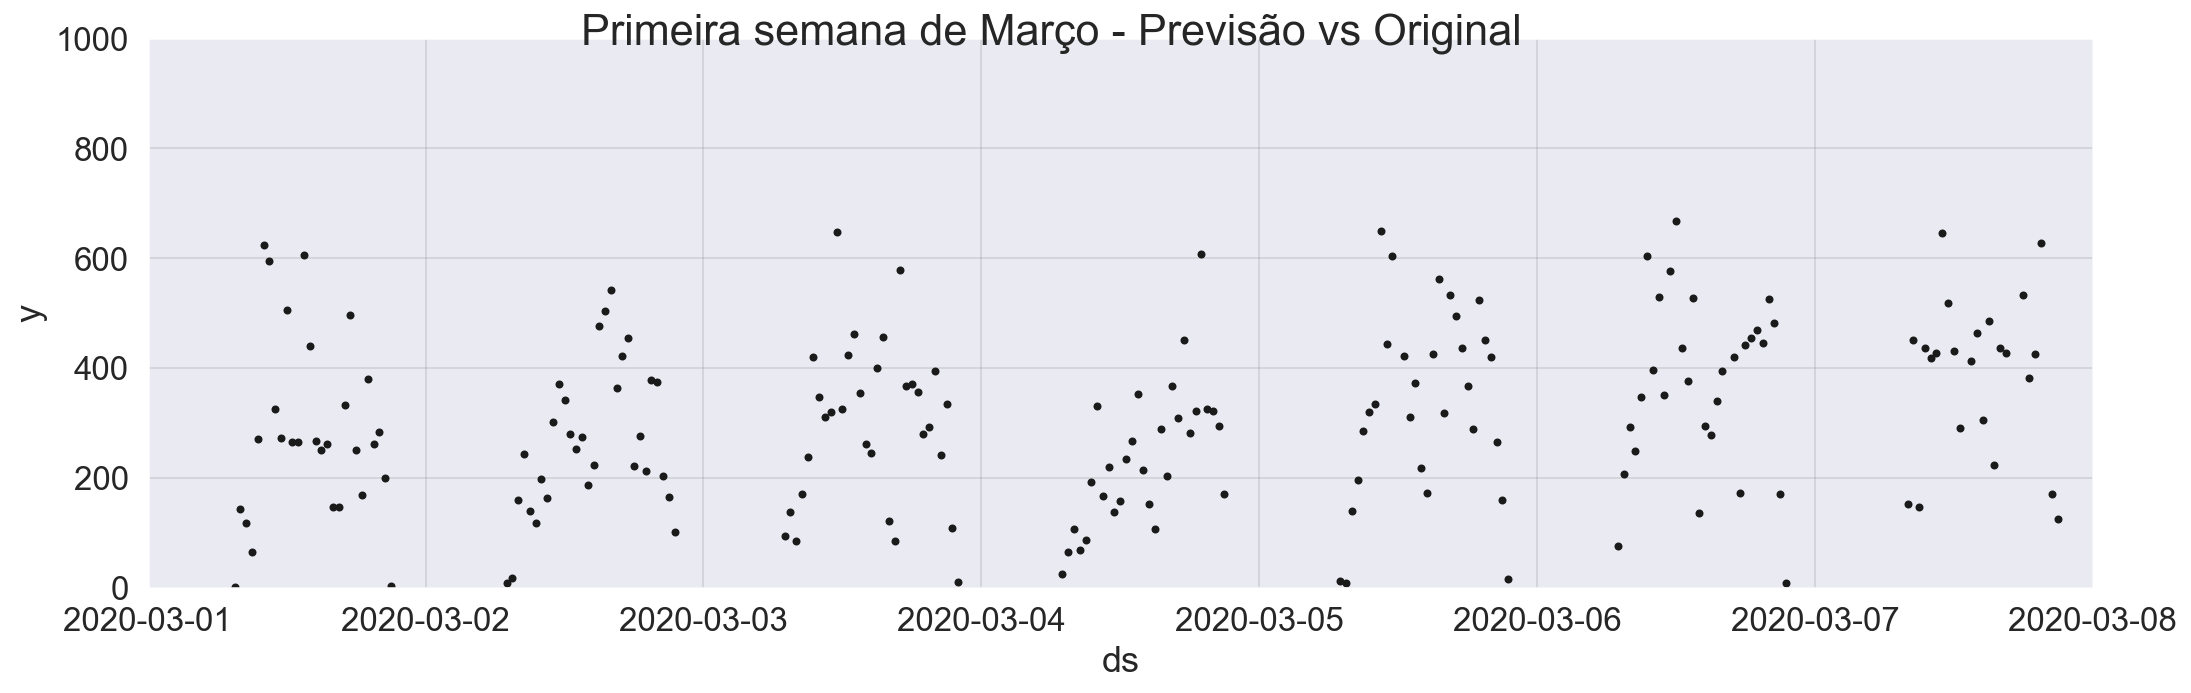

In [49]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sem_outliers_teste.ds, df_274_sem_outliers_teste['y'], color='r')
fig = prophet_no_outliers.plot(df_274_no_outliers_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-03-01', upper='2020-03-08')
ax.set_ylim(0, 1000)
plot = plt.suptitle('Primeira semana de Março - Previsão vs Original')

In [50]:
mape_sem_feriados = dtexp.mean_absolute_percentage_error(df_274_sem_outliers_teste['y'],df_274_no_outliers_teste_forecast['yhat'])
print("MAPE",round(mape_sem_feriados,4))

MAPE 127.5587


In [51]:
iplot(dtview.compare_dataframes_with_bar(
        df_274_sem_outliers_teste,
        df_274_no_outliers_teste_forecast,
        nametrace1='Valor Real (sem outliers)',
        nametrace2='Valor Previsto (sem outliers)',
        idx_end=28))

In [52]:
prophet_feriados_s_outliers = Prophet(holidays=feriados)

prophet_feriados_s_outliers.add_country_holidays('BR')
prophet_feriados_s_outliers.fit(df_274_sem_outliers_treino)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em horas (os dados estão em horas)
future_feriados_s_outliers = prophet_feriados_s_outliers.make_future_dataframe(freq='D', periods=8)
# Prevendo os valores
forecast_feriados_s_outliers = prophet_feriados_s_outliers.predict(future_feriados_s_outliers)
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_feriados_s_outliers['ds'] = pd.to_datetime(future_feriados_s_outliers['ds'])
future_feriados_s_outliers = future_feriados_s_outliers.set_index(pd.DatetimeIndex(future_feriados_s_outliers['ds']))
future_feriados_s_outliers = future_feriados_s_outliers.between_time('08:00','21:00')
# Previsão optimizada dos valores
future_feriados_s_outliers = prophet_feriados_s_outliers.predict(future_feriados_s_outliers)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


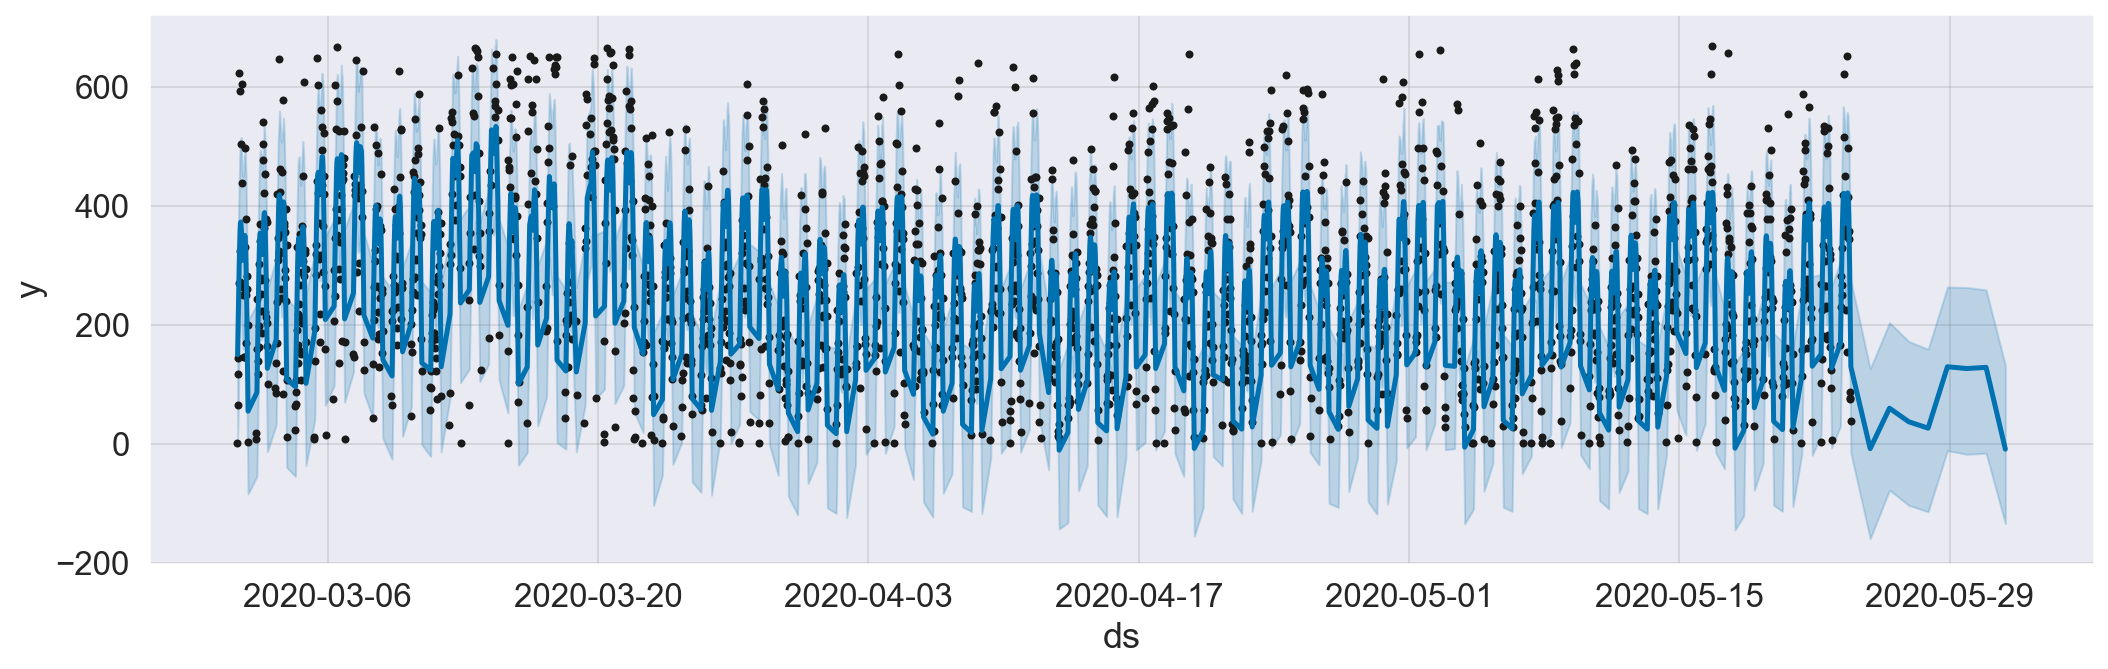

In [53]:
plt,fig_forecast_feriado_s_outliers = dtview.plot_forecast(future_feriados_s_outliers,prophet_feriados_s_outliers,f,ax)
plt.show()

# Visualizando os componentes do modelo

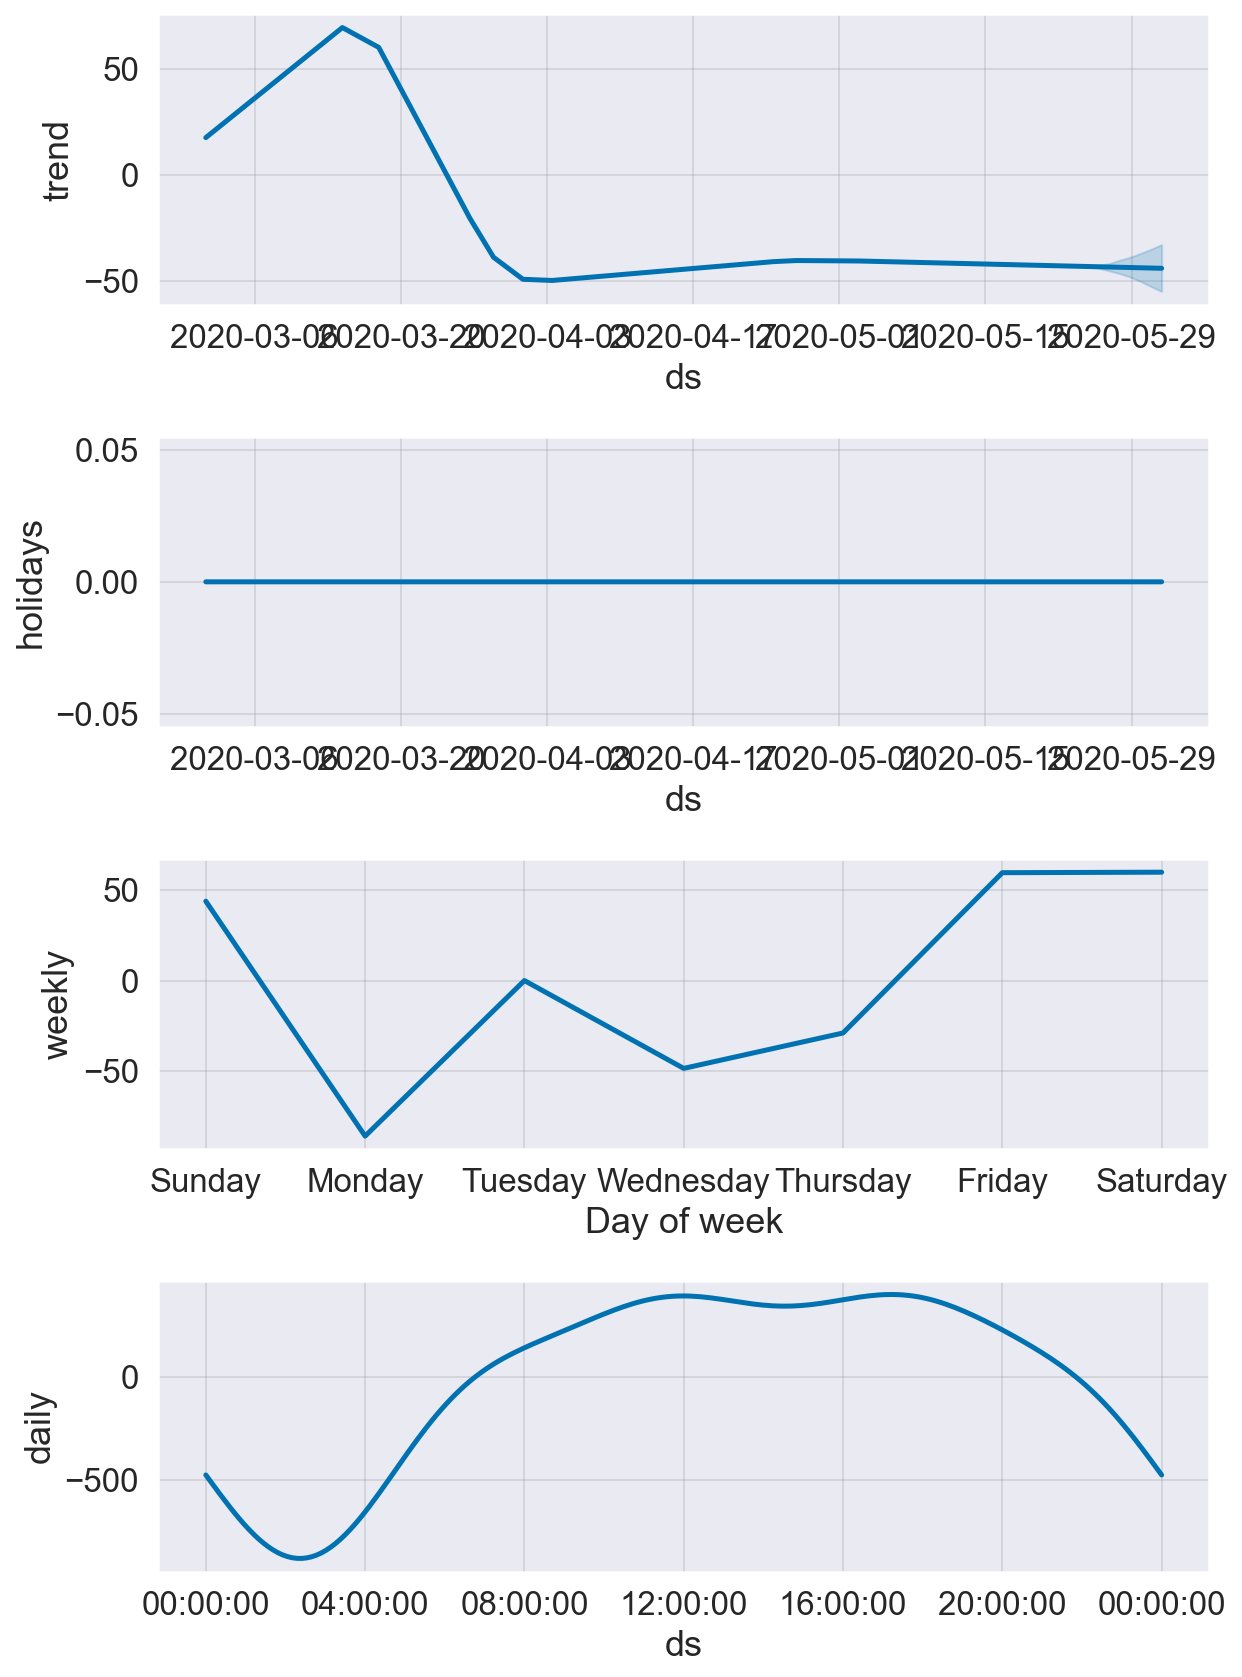

In [54]:
fig_forecast_feriado_s_outliers = prophet_feriados_s_outliers.plot_components(forecast_feriados_s_outliers)

In [55]:
forecast_teste_feriados_s_outliers = prophet_feriados_s_outliers.predict(df_274_sem_outliers_teste)
iplot(dtview.plot_forecast_as_table(forecast_teste_feriados_s_outliers))

# Visualizar dataframe de teste previsto e original com feriados

In [56]:
iplot(dtview.compare_dataframes_with_scatter(
    df_274_sem_outliers_teste,
    forecast_teste_feriados_s_outliers,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [60]:
mape_com_feriados = dtexp.mean_absolute_percentage_error(df_274_sem_outliers_teste.y,forecast_teste_feriados_s_outliers.yhat)
print("MAPE",round(mape_com_feriados,4))
strt = '2020-06-01 06:00:00'
end = '2020-06-08 18:00:00'
actual = df_274_sem_outliers_teste[(df_274_sem_outliers_teste['ds']>strt)&(df_274_sem_outliers_teste['ds']<=end)]
actual.shape

MAPE 133.7907


(0, 2)

In [ ]:
dtexp.tuning_model(df_274_sem_outliers_treino,df_sem_outliers,periodo=219,frequencia='D',loja='274',tipo='vendas_s_outliers')

{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 111.60968381688807
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 111.60968381688807
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 111.60968381688807
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 3931.1381542690187
{'changepoint_prior_scale': 15

Mean Absolute Percentage Error(MAPE)------------------------------------ 3964.601668273811
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 3964.601668273811
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 111.60968381688807
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 111.60968381688807
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(M

In [ ]:
# Configurando e treinando o modelo com feriados e parâmetros otimizados
final_prophet_s_outliers = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 15,
                      holidays_prior_scale = 15,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 25,
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_prophet_s_outliers.add_country_holidays(country_name='BR')
final_prophet_s_outliers.fit(df_274_sem_outliers_treino)

In [ ]:
future_final_s_outliers = final_prophet_s_outliers.make_future_dataframe(periods=122, freq='D')
forecast_final_s_outliers = final_prophet_s_outliers.predict(future_final_s_outliers)
iplot(dtview.plot_forecast_as_table(forecast_final_s_outliers))

In [ ]:
iplot(dtview.plot_forecast_as_table(forecast_final_s_outliers))

In [ ]:
# Plot the components of the model
fig = final_prophet_s_outliers.plot_components(forecast_final_s_outliers)

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_prophet_s_outliers.plot(forecast_final_s_outliers,ax=ax)
plt.show()

In [ ]:
# Visualizando a tabela prevista

df_teste_final_s_outliers= final_prophet_s_outliers.predict(df_274_sem_outliers_teste)
iplot(dtview.plot_forecast_as_table(df_teste_final_s_outliers))

In [ ]:
# Comparando os dataframes em gráfico scatter

iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_teste,
                                   df_teste_final_s_outliers,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [ ]:
# Comparando os dataframes em gráfico de barras

iplot(dtview.compare_dataframes_with_bar(
    df_274_sem_outliers_teste,
    df_teste_final_s_outliers,
    nametrace1='Teste',
    nametrace2='Previsto'))

In [ ]:
# Calculando o mape

mape_final = dtexp.mean_absolute_percentage_error(df_274_sem_outliers_teste['y'],df_teste_final_s_outliers['yhat'])
print("MAPE",round(mape_final,4))

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sem_outliers_teste.ds, df_274_sem_outliers_teste['y'], color='r')
fig = prophet_no_outliers.plot(df_274_no_outliers_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-03-01', upper='2020-03-08')
ax.set_ylim(0, 1000)
plot = plt.suptitle('Primeira semana de Março - Previsão vs Original')

In [ ]:
mape_sem_feriados = dtexp.mean_absolute_percentage_error(df_274_sem_outliers_teste['y'],df_274_no_outliers_teste_forecast['yhat'])
print("MAPE",round(mape_sem_feriados,4))

In [ ]:
iplot(dtview.compare_with_bar(
        df_274_sem_outliers_teste,
        df_274_no_outliers_teste_forecast,
        nametrace1='Valor Real (sem outliers)',
        nametrace2='Valor Previsto (sem outliers)',
        idx_end=28))

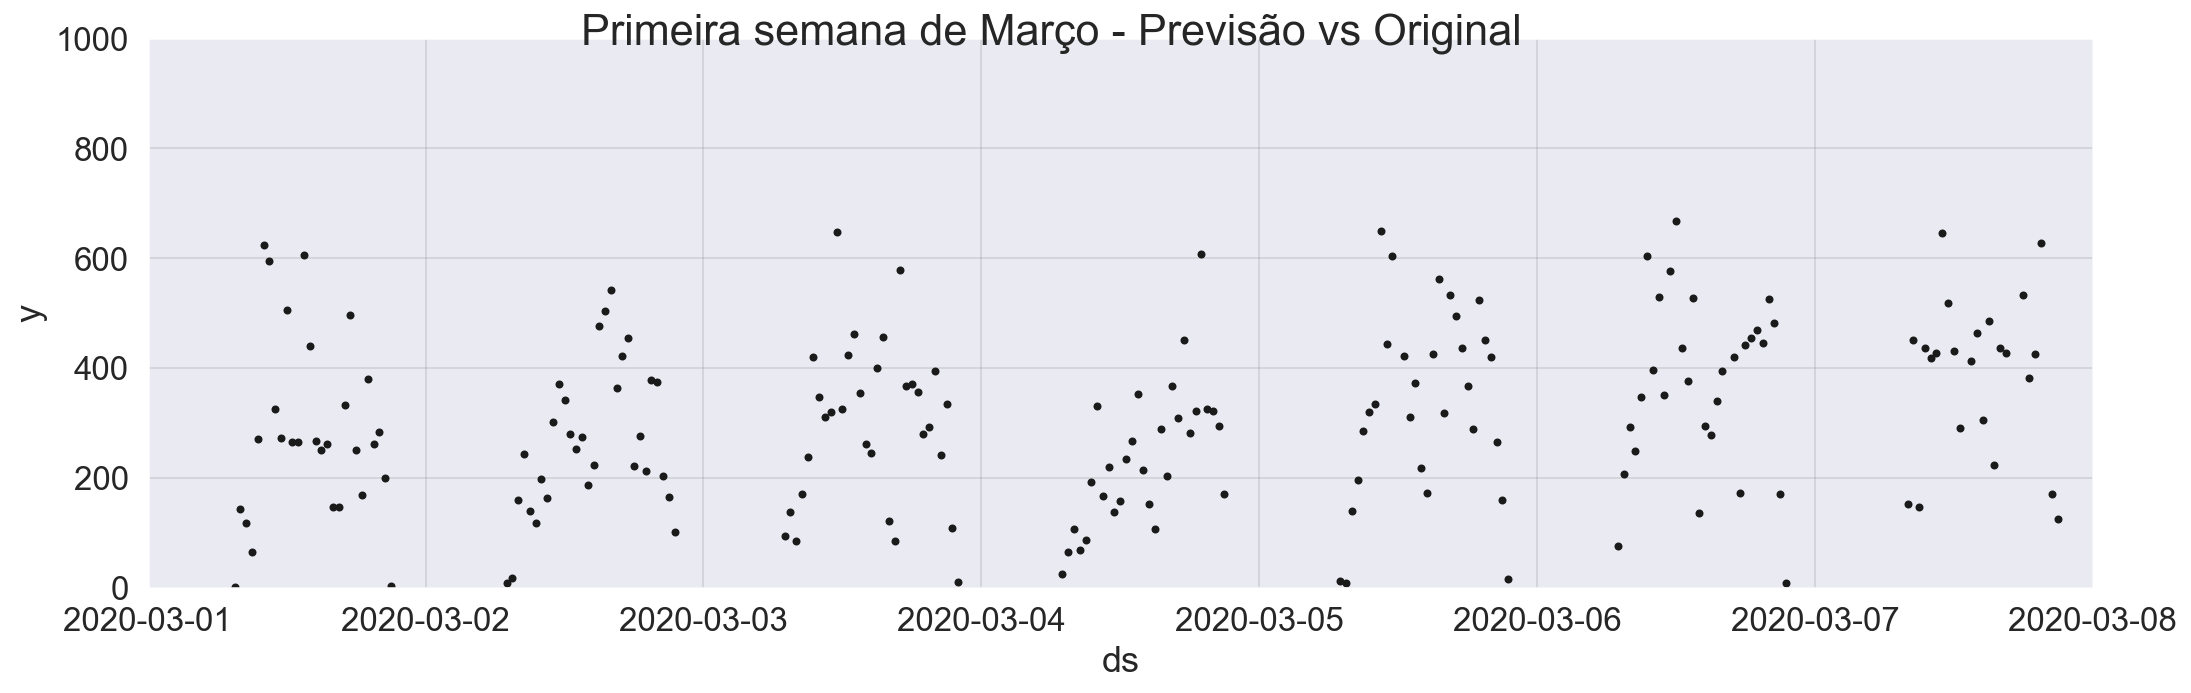

In [62]:
mape_sem_feriados = dtexp.mean_absolute_percentage_error(df_274_sem_outliers_teste['y'],df_274_no_outliers_teste_forecast['yhat'])
print("MAPE",round(mape_sem_feriados,4))

MAPE 127.5587


In [64]:
iplot(dtview.compare_with_bar(
        df_274_sem_outliers_teste,
        df_274_no_outliers_teste_forecast,
        nametrace1='Valor Real (sem outliers)',
        nametrace2='Valor Previsto (sem outliers)',
        idx_end=28))

AttributeError: module 'view.data_visualization' has no attribute 'compare_with_bar'